In [ ]:
import pandas as pd # Manejo de datos
import numpy as np # Cálculos numéricos
import matplotlib.pyplot as plt # Gráficas
import seaborn as sns # Gráficas avanzadas
from sklearn.preprocessing import StandardScaler  # Escalado
from sklearn.decomposition import PCA  # Reducción de dimensiones
from sklearn.cluster import KMeans, DBSCAN  # Algoritmos de clustering
from sklearn.metrics import silhouette_score  # Métrica de calidad de clusters
from sklearn.neighbors import NearestNeighbors  # Para optimizar DBSCAN

In [ ]:
datos = pd.read_csv("D:/DocumentsD/ecbd/2daevaluacion/data/samsung.csv")  # Leesmos el dataset

In [ ]:
datos["Close"] = datos["Close"].astype(str).str.replace(",", "").astype(float)
datos["Volume"] = datos["Volume"].astype(str).str.replace(",", "").astype(float)

In [ ]:
datos["cambio_pct"] = datos["Close"].pct_change() # Cambio porcentual
datos["media_5"] = datos["Close"].rolling(5).mean() # Media móvil 5 días
datos["media_20"] = datos["Close"].rolling(20).mean() # Media móvil 20 días

variables = ["Close", "Volume", "cambio_pct", "media_5", "media_20"]
datos_limpios = datos[variables].dropna() # Limpiamos los datos que son nulos

In [ ]:
escalador = StandardScaler() # Escalamos los datos
X = escalador.fit_transform(datos_limpios) # Datos escalados 

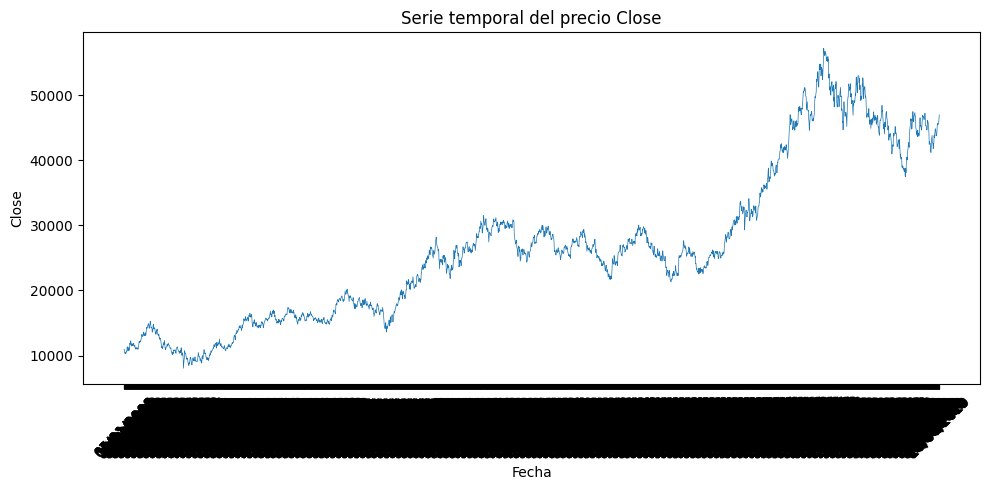

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(datos["Date"], datos["Close"], linewidth=0.5)
plt.title("Serie temporal del precio Close")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

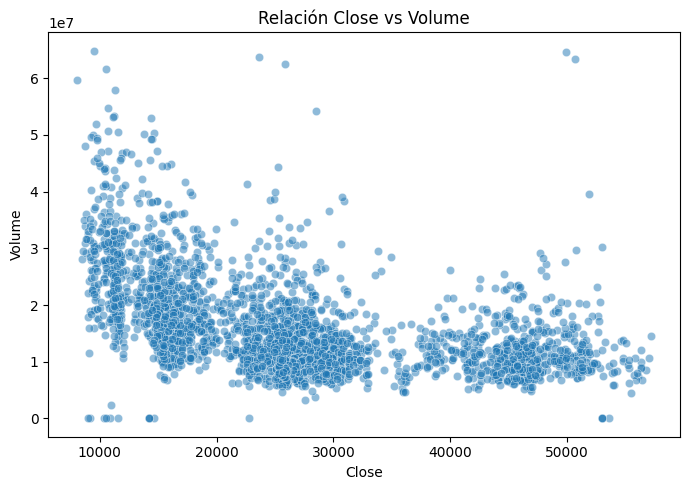

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=datos_limpios["Close"], y=datos_limpios["Volume"], alpha=0.5)
plt.title("Relación Close vs Volume")
plt.xlabel("Close")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

In [ ]:
puntajes_sil = []  # Lista para guardar los valores del índice silhouette de cada k
rango_k = range(2, 10)  # Rango de posibles valores de k a probar

In [ ]:
print("\nMétricas de los KMeans")
for k in rango_k:
    modelo_temp = KMeans(n_clusters=k, n_init=10, random_state=42) # Creamos un modelo KMeans temporal para cada k
    etiquetas_temp = modelo_temp.fit_predict(X) # Ajustamos el modelo y obtenemos las etiquetas de los clusters
    score = silhouette_score(X, etiquetas_temp) # Calculamos el índice silhouette para evaluar la calidad del clustering
    puntajes_sil.append(score) # Guardamos el valor de silhouette en la lista

    print(f"K={k} - silhouette={score}")


Métricas de los KMeans
K=2 - silhouette=0.46837489392901815
K=3 - silhouette=0.3893166768216562
K=4 - silhouette=0.39520230306369925
K=5 - silhouette=0.3860918977020069
K=6 - silhouette=0.3387051161862496
K=7 - silhouette=0.29447987009116705
K=8 - silhouette=0.2961788956339972
K=9 - silhouette=0.29016242249432045


In [ ]:
mejor_k = rango_k[np.argmax(puntajes_sil)] # Seleccionamos el k con mejor índice silhouette
print("\nMejor k según silhouette:", mejor_k)


Mejor k según silhouette: 2


In [ ]:
kmeans = KMeans(n_clusters=mejor_k, n_init=50, random_state=42)  # Modelo final
etiquetas_kmeans = kmeans.fit_predict(X)  # Aplicamos clustering con el mejor k

sil_final = silhouette_score(X, etiquetas_kmeans) # Calculamos el silhouette final del clustering

In [ ]:
print("\nMétricas finales de KMeans")
print("Silhouette final:", round(sil_final, 4))


Métricas finales de KMeans
Silhouette final: 0.4684


In [ ]:
clases, cantidades = np.unique(etiquetas_kmeans, return_counts=True) # Obtenemos los clusters únicos y la cantidad de puntos en cada cluster
print("\nTamaño de los clusters:")
for c, n in zip(clases, cantidades):
    print(f"Cluster {c}: {n} puntos")

pca = PCA(n_components=2)  # Reducimos los datos a 2 componentes principales
X_pca = pca.fit_transform(X)  # Aplicamos PCA a los datos escalados

colores_kmeans = sns.color_palette("Set1", len(clases)) # Definimos colores para cada cluster para graficar


Tamaño de los clusters:
Cluster 0: 2197 puntos
Cluster 1: 634 puntos


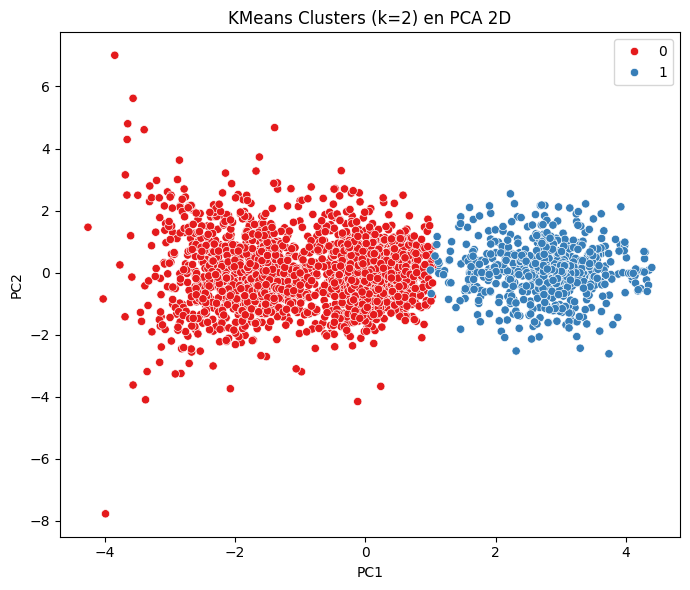

In [ ]:
# Gráficas de los clusters en el espacio PCA
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=etiquetas_kmeans,
    palette=colores_kmeans,
    legend="full"
)
plt.title(f"KMeans Clusters (k={mejor_k}) en PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [ ]:
vecinos = NearestNeighbors(n_neighbors=5).fit(X) # Encontrar a los clusteres vecinos más cercanos
distancias, _ = vecinos.kneighbors(X) # Calcular las distancias a los vecinos más cercanos
dist_ordenado = np.sort(distancias[:,4]) # Ordenamos las distancias del 5to vecino

eps_optimo = np.percentile(dist_ordenado, 85) # Elegimos el percentil 85 como eps óptimo

dbscan = DBSCAN(eps=eps_optimo, min_samples=5) # Configuramos DBSCAN con eps óptimo
etiquetas_dbscan = dbscan.fit_predict(X) # Aplicamos DBSCAN a los datos

In [ ]:
print("\nMétricas DBSCAN")
print("EPS Calculado:", round(eps_optimo, 5))


Métricas DBSCAN
EPS Calculado: 0.40111


In [ ]:
clases_db = np.unique(etiquetas_dbscan)
print("Clusters detectados:", clases_db)

clases, cantidades = np.unique(etiquetas_dbscan, return_counts=True)
for c, n in zip(clases, cantidades):
    tipo = "Ruido" if c == -1 else f"Cluster {c}"
    print(f"{tipo}: {n} puntos")

if len(clases_db) > 1:
    try:
        sil_db = silhouette_score(X, etiquetas_dbscan)
        print("Silhouette DBSCAN:", round(sil_db, 4))
    except:
        print("Silhouette no válida por exceso de ruido.")

colores_db = sns.color_palette("Dark2", len(clases_db))

Clusters detectados: [-1  0  1  2  3  4  5]
Ruido: 272 puntos
Cluster 0: 2523 puntos
Cluster 1: 9 puntos
Cluster 2: 9 puntos
Cluster 3: 7 puntos
Cluster 4: 8 puntos
Cluster 5: 3 puntos
Silhouette DBSCAN: -0.2353


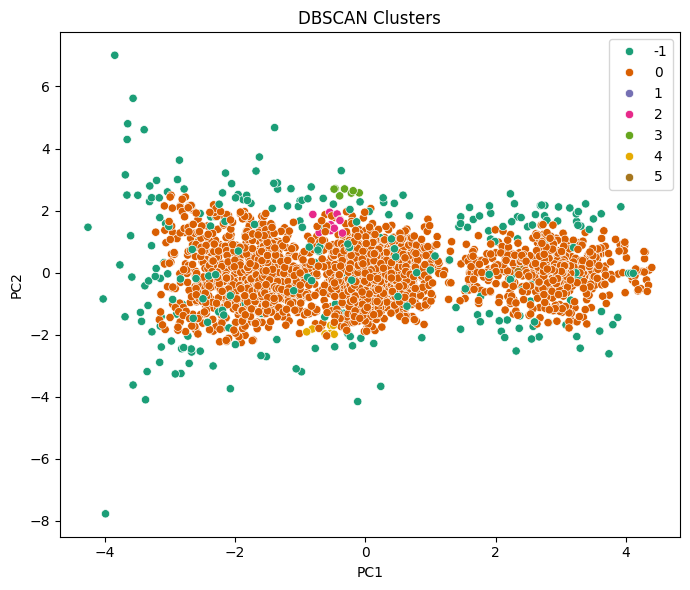

In [ ]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=etiquetas_dbscan,
    palette=colores_db,
    legend="full"
)
plt.title("DBSCAN Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()